# Training and Evaluating Naive Bayes Classifier on Synthetic Data


Step 3a: [for probabilistic/generative models only] Train and apply your solution to synthetic data that
aligns with the assumptions made by the model.
Evaluate the results quantitatively and qualitatively: highlight examples where the model performs well and
poorly. Any unusual/unexpected results require explanation (and frankly, probably debugging).


# Code from other notebook

In [3]:
# Load in libraries and data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import re
import math
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")


In [4]:
#PREPROCESSING CODE

nltk.download("stopwords")
nltk.download("wordnet")

stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# makes everything lowercase, removes punctuation, lemmatizes, and removes stopwords
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = " ".join([lemmatizer.lemmatize(word) for word in t.split() if word not in stop])
    return t

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pdeguz01/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pdeguz01/nltk_data...


In [5]:
# load in new subset
df_subset = pd.read_csv("data/top500_patents.csv")

# combine section and class, then clean text
df_subset["Combined_ipc_clean"] = (
    df_subset["ipc_sections"] + "_" + df_subset["ipc_classes"].astype(str)
)

# combine title and abstract for easier classification
df_subset["text_clean"] = (
    (df_subset["patent_title"] + ": " + df_subset["patent_abstract"])
    .astype(str)
    .apply(clean_text)
)

In [6]:
df_subset["Combined_ipc_clean"].value_counts()

Combined_ipc_clean
A_61                2483
G_06                2171
G_6                 1651
H_04                1244
G;H_4;6              731
                    ... 
A;B;G_1;25;43;6        1
A;G_1;16;4;43;63       1
A;G_16;41;61           1
A_41;44                1
B;H_5;60               1
Name: count, Length: 1735, dtype: int64

In [7]:
#Additional Data Cleaning

# drop under 50 observations
df_subset = df_subset.groupby("Combined_ipc_clean").filter(lambda x: len(x) >= 50)

# remove the duplicate rows
dups_to_remove = ["H_4", "G_1", "B_1", "G_6", "C_7"]
for dup in dups_to_remove:
    df_subset = df_subset[df_subset["Combined_ipc_clean"] != dup]

# Train and test Naive Bayes

In [8]:
# Inputs and labels
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y_bayes, random_state=42
)

# Build model
class_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=50000)),
        ("nb", ComplementNB()),
    ]
)

# Train
class_model.fit(X_train_bayes, y_train_bayes)

# Evaluate
preds = class_model.predict(X_test_bayes)
print("IPC Class Accuracy:", accuracy_score(y_test_bayes, preds))
print(classification_report(y_test_bayes, preds))

IPC Class Accuracy: 0.6889058330156309
              precision    recall  f1-score   support

A;C_07;12;61       0.00      0.00      0.00        13
   A;C_07;61       0.50      0.83      0.63       103
    A;C_61;7       0.73      0.70      0.71        73
    A;G_6;63       1.00      0.09      0.17        11
        A_23       0.91      0.83      0.87        12
        A_43       0.85      0.98      0.91        51
        A_46       0.50      0.13      0.21        15
     A_46;61       0.83      0.36      0.50        14
        A_61       0.79      0.90      0.84       497
        A_63       0.89      0.89      0.89        44
       B;C_1       0.54      0.70      0.61        10
    B;C_1;10       0.69      0.35      0.46        26
     B;C_1;7       1.00      0.20      0.33        20
    B;G_6;60       0.00      0.00      0.00        10
        B_01       0.38      0.14      0.20        22
        B_26       0.88      0.84      0.86        58
        B_29       0.89      0.85      0.8

In [14]:
df_subset.columns

Index(['SYMBOL', 'SUBSIDIARY', 'patent_id', 'patent_title', 'patent_date',
       'patent_year', 'patent_type', 'withdrawn', 'assignee_organization',
       'ipc_sections', 'ipc_classes', 'ipc_subclasses', 'patent_abstract',
       'Combined_ipc_clean', 'text_clean'],
      dtype='object')

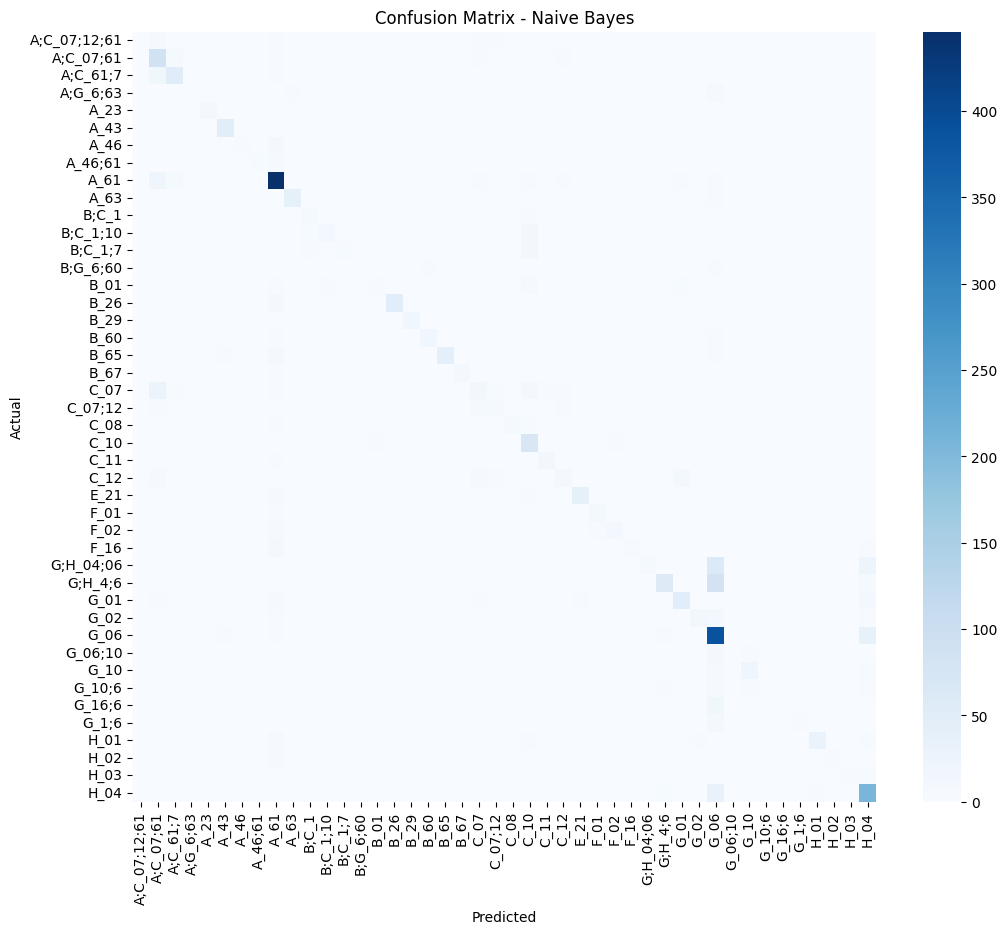

In [9]:
# Predictions
y_pred = class_model.predict(X_test_bayes)

# Confusion matrix
cm = confusion_matrix(y_test_bayes, y_pred, labels=class_model.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_model.classes_,
    yticklabels=class_model.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

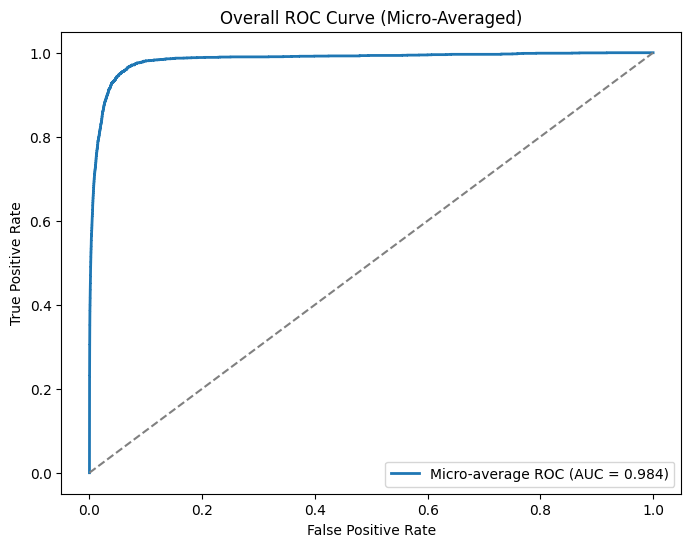

Overall AUC ROC: 0.9835539725057953


In [10]:
# Get the classes
classes = sorted(y_test_bayes.unique())

# Binarize true labels
y_test_bin = label_binarize(y_test_bayes, classes=classes)

# Predict probability estimates
y_proba = class_model.predict_proba(X_test_bayes)

# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"Micro-average ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve (Micro-Averaged)")
plt.legend()
plt.show()

print("Overall AUC ROC:", roc_auc)

# Visualize Results


In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np


def plot_learning_curve(estimator, title, X, y):
    plt.figure(figsize=(8, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8),
        scoring="accuracy",
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")

    # Train accuracy
    plt.plot(train_sizes, train_mean, label="Training Accuracy")
    plt.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2
    )

    # Validation accuracy
    plt.plot(train_sizes, test_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.legend()
    plt.grid(True)
    plt.show()


# Create models
# svc_model = Pipeline(
#     [("tfidf", TfidfVectorizer(stop_words="english")), ("clf", LinearSVC())]
# )

nb_model = Pipeline(
    [("tfidf", TfidfVectorizer(stop_words="english")), ("clf", MultinomialNB())]
)

# Plot learning curves
#plot_learning_curve(svc_model, "Learning Curve: LinearSVC", X_svc, y_svc)
plot_learning_curve(nb_model, "Learning Curve: Multinomial Naive Bayes", X_bayes, y_bayes)

In [13]:
def normalize_ipc_label(label: str) -> str:
    # Handle composite labels (e.g., H;G:06) by taking the first section
    if ";" in label:
        label = label.split(";")[0]

    # Extract the IPC Section (A, B, C...)
    match = re.search(r"^[A-H]", label)  # IPC sections go from A to H
    if match:
        return match.group(0)

    return "UNKNOWN"


# Examples using the function:
# normalize_ipc_label('A_01')     # -> 'A'
# normalize_ipc_label('A:C:07')   # -> 'A'
# normalize_ipc_label('G;H:04')   # -> 'G' (first section)

# Trying this with Synthetic Data


In [21]:
unique_classes = df_subset['Combined_ipc_clean'].unique()
print(unique_classes)

['G_06' 'H_04' 'A_61' 'A;C_61;7' 'A;C_07;61' 'C_07' 'G_16;6' 'G;H_4;6'
 'H_02' 'G_02' 'H_01' 'A;C_07;12;61' 'C_07;12' 'A_63' 'A;G_6;63'
 'G;H_04;06' 'G_10' 'B_65' 'F_16' 'G_01' 'B_26' 'B_29' 'A_43' 'A_46'
 'A_46;61' 'B_60' 'H_03' 'B_67' 'C_12' 'G_06;10' 'B;C_1;10' 'C_10' 'B_01'
 'E_21' 'C_08' 'C_11' 'F_02' 'G_1;6' 'B;C_1' 'B;C_1;7' 'A_23' 'F_01'
 'G_10;6' 'B;G_6;60']


In [27]:
import numpy as np
import pandas as pd

np.random.seed(42)

# List of IPC classes from your data
classes = [
    'G_06','H_04','A_61','A;C_61;7','A;C_07;61','C_07','G_16;6','G;H_4;6',
    'H_02','G_02','H_01','A;C_07;12;61','C_07;12','A_63','A;G_6;63',
    'G;H_04;06','G_10','B_65','F_16','G_01','B_26','B_29','A_43','A_46',
    'A_46;61','B_60','H_03','B_67','C_12','G_06;10','B;C_1;10','C_10','B_01',
    'E_21','C_08','C_11','F_02','G_1;6','B;C_1','B;C_1;7','A_23','F_01',
    'G_10;6','B;G_6;60'
]
# Generate synthetic vocabulary for each class
# We'll use 5-7 distinctive words per class
class_vocab = {
    'G_06': ["network", "algorithm", "compute", "data", "process", "machine"],
    'H_04': ["signal", "communication", "transmit", "channel", "frequency", "modulation"],
    'A_61': ["medical", "device", "surgery", "treatment", "patient", "health"],
    'A;C_61;7': ["chemical", "compound", "reaction", "acid", "solution", "synthesis"],
    'A;C_07;61': ["drug", "therapy", "molecule", "pharma", "treatment", "dose"],
    'C_07': ["organic", "reaction", "synthesis", "compound", "catalyst", "solution"],
    'G_16;6': ["computer", "software", "data", "algorithm", "system", "processing"],
    'G;H_4;6': ["network", "protocol", "signal", "transmission", "error", "coding"],
    'H_02': ["telecom", "signal", "modulation", "channel", "data", "transmit"],
    'G_02': ["imaging", "sensor", "signal", "measurement", "processing", "analysis"],
    'H_01': ["electronics", "circuit", "voltage", "current", "device", "component"],
    'A;C_07;12;61': ["compound", "reaction", "drug", "therapy", "molecule", "pharma"],
    'C_07;12': ["synthesis", "organic", "compound", "reaction", "molecule"],
    'A_63': ["game", "sport", "entertainment", "toy", "device", "play"],
    'A;G_6;63': ["computer", "device", "software", "system", "interface"],
    'G;H_04;06': ["signal", "communication", "network", "channel", "transmission"],
    'G_10': ["mechanical", "machine", "engine", "device", "process"],
    'B_65': ["packaging", "container", "material", "product", "process"],
    'F_16': ["mechanical", "engine", "gear", "device", "machine"],
    'G_01': ["measurement", "sensor", "instrument", "signal", "data"],
    'B_26': ["metal", "alloy", "cutting", "process", "tool"],
    'B_29': ["plastic", "molding", "material", "process", "product"],
    'A_43': ["hair", "cosmetic", "care", "brush", "device"],
    'A_46': ["clothing", "design", "fabric", "pattern", "material"],
    'A_46;61': ["textile", "fabric", "sewing", "material", "design"],
    'B_60': ["vehicle", "engine", "transport", "car", "wheel"],
    'H_03': ["electronics", "circuit", "signal", "power", "device"],
    'B_67': ["container", "tank", "liquid", "fluid", "pipe"],
    'C_12': ["biotech", "enzyme", "cell", "microbe", "reaction"],
    'G_06;10': ["software", "computer", "algorithm", "system", "data"],
    'B;C_1;10': ["chemical", "process", "compound", "reaction", "material"],
    'C_10': ["chemical", "reaction", "compound", "acid", "solution"],
    'B_01': ["process", "material", "equipment", "reaction", "flow"],
    'E_21': ["drilling", "oil", "well", "engine", "pump"],
    'C_08': ["polymer", "material", "compound", "synthesis", "reaction"],
    'C_11': ["oil", "chemical", "process", "refine", "compound"],
    'F_02': ["engine", "turbine", "combustion", "mechanical", "airflow"],
    'G_1;6': ["sensor", "signal", "measurement", "data", "processing"],
    'B;C_1': ["chemical", "compound", "reaction", "process", "material"],
    'B;C_1;7': ["chemical", "reaction", "compound", "process", "catalyst"],
    'A_23': ["medical", "treatment", "therapy", "patient", "drug"],
    'F_01': ["engine", "mechanical", "device", "combustion", "turbine"],
    'G_10;6': ["mechanical", "device", "engine", "gear", "system"],
    'B;G_6;60': ["process", "material", "engine", "chemical", "reaction"]
}

In [34]:
# Base class vocab (distinct words per class)
class_vocab = {cls: [f"{cls}_word{i}" for i in range(5)] for cls in classes}

# Shared words across all classes
shared_words = ["data", "system", "device", "process", "method"]

# Noise words (random filler)
noise_words = ["sample", "example", "info", "text", "random"]

# Add shared and noise words to class vocab
for cls in classes:
    class_vocab[cls] += shared_words
    class_vocab[cls] += list(np.random.choice(noise_words, size=3))

def generate_synthetic_text(classes, class_vocab, n_docs_per_class=100):
    texts = []
    labels = []

    all_words = [w for vocab in class_vocab.values() for w in vocab]

    for cls in classes:
        vocab = class_vocab[cls]

        for _ in range(n_docs_per_class):
            doc_length = np.random.randint(20, 40)  # shorter docs

            # Only 30-40% words from class vocab
            n_cls = int(doc_length * 0.35)
            n_other = doc_length - n_cls

            doc_words = list(np.random.choice(vocab, size=n_cls, replace=True))

            # 65% of words are from other classes/noise
            doc_words += list(np.random.choice(all_words, size=n_other, replace=True))

            np.random.shuffle(doc_words)
            texts.append(" ".join(doc_words))
            labels.append(cls)

    return pd.Series(texts), pd.Series(labels)



# Generate synthetic dataset
X_syn, y_syn = generate_synthetic_text(classes, class_vocab, n_docs_per_class=100)
print("Synthetic dataset size:", len(X_syn))


Synthetic dataset size: 4400


In [ ]:
X_syn, y_syn = generate_synthetic_text(classes, class_vocab, n_docs_per_class=100)

X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, stratify=y_syn, random_state=42
)

# Naive Bayes pipeline
class_model_syn = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("nb", ComplementNB()),
])

# Train

class_model_syn.fit(X_train_syn, y_train_syn)
preds_syn = class_model_syn.predict(X_test_syn)

from sklearn.metrics import accuracy_score, classification_report
print("Synthetic Data Accuracy:", accuracy_score(y_test_syn, preds_syn))
print(classification_report(y_test_syn, preds_syn))


Synthetic Data Accuracy: 0.8863636363636364
              precision    recall  f1-score   support

A;C_07;12;61       0.90      0.90      0.90        20
   A;C_07;61       1.00      0.50      0.67        20
    A;C_61;7       0.90      0.90      0.90        20
    A;G_6;63       0.82      0.90      0.86        20
        A_23       1.00      0.95      0.97        20
        A_43       0.94      0.85      0.89        20
        A_46       0.85      0.85      0.85        20
     A_46;61       1.00      0.95      0.97        20
        A_61       0.87      1.00      0.93        20
        A_63       0.83      0.95      0.88        20
       B;C_1       0.86      0.90      0.88        20
    B;C_1;10       0.94      0.75      0.83        20
     B;C_1;7       1.00      0.75      0.86        20
    B;G_6;60       0.83      0.95      0.88        20
        B_01       0.90      0.90      0.90        20
        B_26       0.82      0.90      0.86        20
        B_29       0.86      0.95    

In [43]:
from sklearn.metrics import classification_report
import pandas as pd

# Compute report as dict
report_dict = classification_report(y_test_syn, preds_syn, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round numbers for readability
report_df = report_df.round(4)

# Optional: sort by support
#report_df = report_df.sort_values(by='support', ascending=False)

report_df


,precision,recall,f1-score,support
A;C_07;12;61,0.8571,0.9000,0.8780,20.0000
A;C_07;61,1.0000,0.5000,0.6667,20.0000
A;C_61;7,1.0000,0.8500,0.9189,20.0000
A;G_6;63,0.8261,0.9500,0.8837,20.0000
A_23,0.8947,0.8500,0.8718,20.0000
A_43,0.8696,1.0000,0.9302,20.0000
A_46,0.8095,0.8500,0.8293,20.0000
A_46;61,0.8571,0.9000,0.8780,20.0000
A_61,0.8636,0.9500,0.9048,20.0000
A_63,1.0000,0.8000,0.8889,20.0000


In [44]:
from tabulate import tabulate

print(tabulate(report_df, headers='keys', tablefmt='grid'))
report_df.to_csv("classification_report.csv")


+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0.8571 |   0.9    |     0.878  |   20      |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      1      |   0.5    |     0.6667 |   20      |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      1      |   0.85   |     0.9189 |   20      |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      0.8261 |   0.95   |     0.8837 |   20      |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0.8947 |   0.85   |     0.8718 |   20      |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.8696 |   1      |     0.9302 |   20      |
+--------------+-------------+----------+------------+--------

In [25]:
# Good prediction example
good_idx = np.where(preds_syn == y_test_syn)[0][0]
print("Correct prediction example:", X_test_syn.iloc[good_idx], y_test_syn.iloc[good_idx])

# Bad prediction example
bad_idx = np.where(preds_syn != y_test_syn)[0][0]
print("Incorrect prediction example:", X_test_syn.iloc[bad_idx],
      "Predicted:", preds_syn[bad_idx], "Actual:", y_test_syn.iloc[bad_idx])


Correct prediction example: drug dose pharma molecule molecule pharma drug molecule drug molecule treatment molecule treatment dose drug molecule therapy therapy pharma therapy treatment therapy therapy therapy molecule pharma drug pharma treatment molecule dose molecule therapy therapy treatment dose molecule dose drug pharma molecule dose drug drug pharma A;C_07;61
Incorrect prediction example: material chemical material reaction reaction material reaction process process reaction compound chemical reaction chemical material compound process reaction compound chemical reaction process process reaction reaction compound process chemical process reaction chemical reaction Predicted: B;C_1;10 Actual: B;C_1
